# Notebook for detecting multi-resolution clonal structures

This notebook reproduces the plots found in the accompanying paper, and loads parameters from a cached output file. Experiments can be re-produced using the scripts found in the above directory. This will also generate additional run-time plots using WandB logging callbacks.

In [1]:
import numpy as np
import pickle as pkl
import torch
import pandas as pd
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style
import palettable
from palettable.colorbrewer.qualitative import Set1_6 as pallette

import TCGA
from WaveletVAE.src.WaveLSTM.models.base import WaveletBase

sns.set()
sns.set_palette(pallette.mpl_colors)

Global seed set to 42
Global seed set to 42
Global seed set to 42


# Get data

In [5]:
# Load data
cancer_types = ['THCA', 'BRCA', 'OV', 'GBM', 'HNSC']
dm = TCGA.data_modules.ascat.loaders.ASCATDataModule(batch_size=256, cancer_types=cancer_types,
                                                     chrom_as_channels=True,
                                                     sampler=False)

data = []
for loader in [dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()]:
    features, labels = [], []
    for batch in iter(loader):
        features.append(batch["feature"])
        labels.append(batch["label"])
    data.append({"feature": torch.concat(features, 0).numpy().reshape((-1, 2, 23, 256)),
                 "label": torch.concat(labels, 0).numpy()}
               )

             chr   startpos     endpos  nMajor  nMinor       patient  \
sample                                                                 
TCGA-06-1084   1      61735   29007668       1       0  TCGA-06-1084   
TCGA-06-1084   1   29007729  200483106       2       1  TCGA-06-1084   
TCGA-06-1084   1  200483591  200709992       4       1  TCGA-06-1084   
TCGA-06-1084   1  200731556  205353468       2       1  TCGA-06-1084   
TCGA-06-1084   1  205353707  230843054       1       0  TCGA-06-1084   

             cancer_type sex                 barcodeTumour  \
sample                                                       
TCGA-06-1084         GBM  XY  TCGA-06-1084-01A-01D-0517-01   
TCGA-06-1084         GBM  XY  TCGA-06-1084-01A-01D-0517-01   
TCGA-06-1084         GBM  XY  TCGA-06-1084-01A-01D-0517-01   
TCGA-06-1084         GBM  XY  TCGA-06-1084-01A-01D-0517-01   
TCGA-06-1084         GBM  XY  TCGA-06-1084-01A-01D-0517-01   

                             barcodeNormal  ...  WGD      GI

In [9]:
# Report counts and order labels
label_order = []
for data_set, data_split in zip(["Training set", "Validation set", "Test set"], data):
    print(f"\n{data_set}\n==================")
    print(f"{data_split['feature'].shape[0]} samples composed of")
    
    for lbl, cnt in zip(*np.unique(data_split['label'], return_counts=True)):
        print(f"Cancer {cancer_types[lbl]} with count {cnt}")

    label_order.append(np.argsort(data_split["label"])
)


Training set
2416 samples composed of
Cancer THCA with count 787
Cancer BRCA with count 417
Cancer OV with count 406
Cancer GBM with count 413
Cancer HNSC with count 393

Validation set
302 samples composed of
Cancer THCA with count 110
Cancer BRCA with count 46
Cancer OV with count 45
Cancer GBM with count 56
Cancer HNSC with count 45

Test set
303 samples composed of
Cancer THCA with count 101
Cancer BRCA with count 39
Cancer OV with count 52
Cancer GBM with count 63
Cancer HNSC with count 48


## Visualise each set's channel's and strands

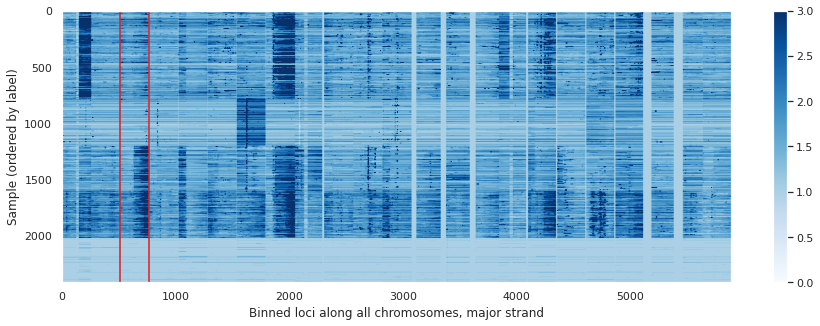

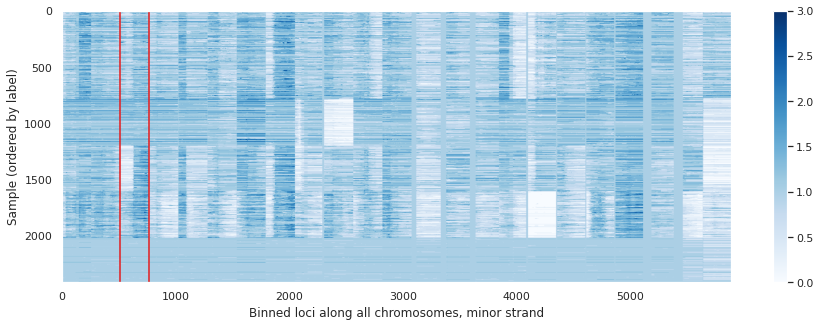

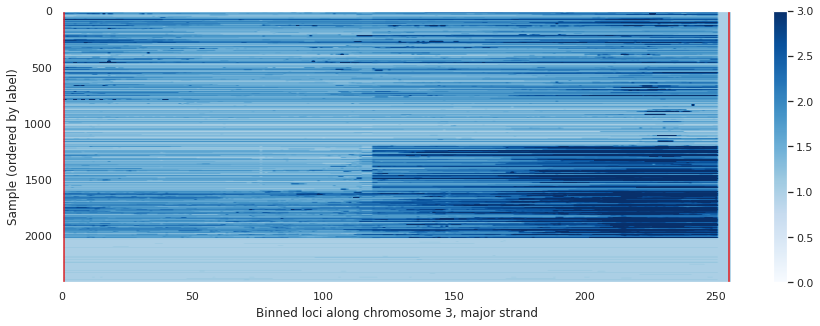

In [11]:
subset = 0           # Training set = 0, Validation set = 1, Test set = 2

# Individual channel and strand
chromosome = 3          # 1,...,22
strand = 1           # 1 or 2

# Stacked channels
for _strand in range(1,3):
    plt.figure(figsize=(15, 5))
    tmp = data[subset]["feature"][label_order[subset], _strand-1, :, :].reshape((-1, 23*dm.W))
    plt.imshow(tmp, aspect='auto', cmap="Blues", vmin=0, vmax=3)
    plt.axvline(x=(chromosome-1)*dm.W)
    plt.axvline(x=(chromosome)*dm.W)
    plt.ylabel("Sample (ordered by label)")
    plt.xlabel(f"Binned loci along all chromosomes, {'major' if _strand == 1 else 'minor'} strand")
    plt.colorbar()
    plt.grid(False)
    plt.show()

plt.figure(figsize=(15, 5))
plt.imshow(data[subset]["feature"][label_order[subset], strand-1, chromosome-1, :], aspect='auto', cmap="Blues", vmin=0, vmax=3)
plt.axvline(x=1)
plt.axvline(x=dm.W-1)
plt.ylabel("Sample (ordered by label)")
plt.xlabel(f"Binned loci along chromosome {chromosome}, {'major' if strand == 1 else 'minor'} strand")
plt.xlim((0,dm.W))
plt.colorbar()
plt.grid(False)
plt.show()

## Due to class imbalance, plot the first 10 of each clone to see more clearly

There are still variations within each clone

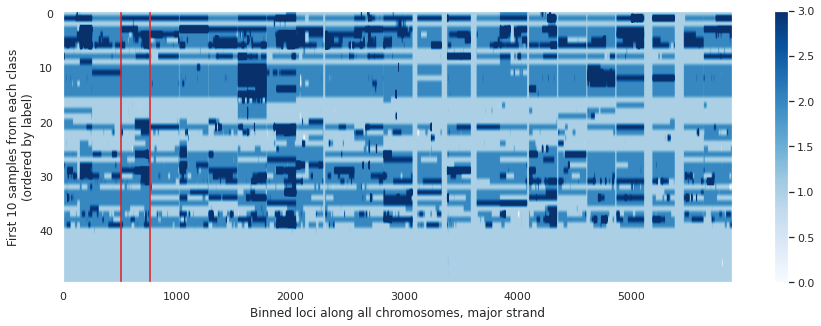

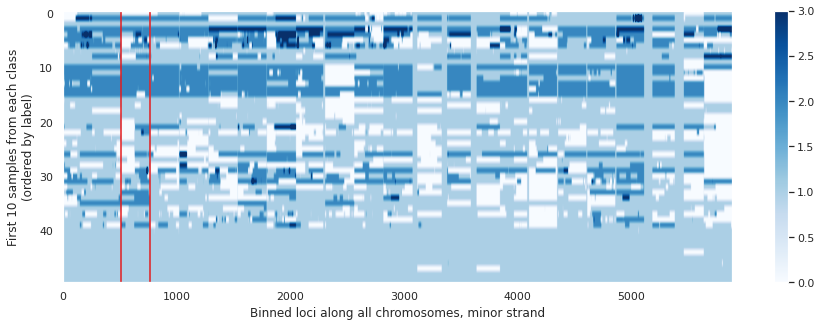

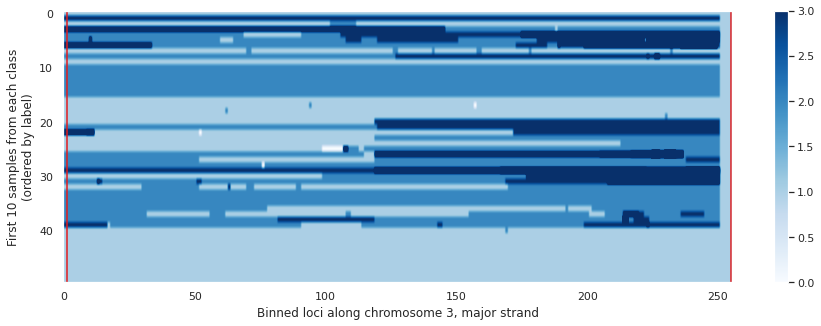

In [15]:
# Individual channel and strand
chromosome = 3          # 1,...,22
strand = 1           # 1 or 2

top_k = [np.where(data[subset]["label"] == l)[0][:10] for l in range(6)]
top_6k = np.concatenate(top_k, 0)

for _strand in range(1,3):
    # Stacked channels
    plt.figure(figsize=(15, 5))
    tmp = data[subset]["feature"][top_6k, _strand-1, :, :].reshape((-1, 23*dm.W))
    plt.imshow(tmp, aspect='auto', cmap="Blues", vmin=0, vmax=3)
    plt.axvline(x=(chromosome-1)*dm.W);   plt.axvline(x=(chromosome)*dm.W)
    plt.ylabel("First 10 samples from each class\n(ordered by label)")
    plt.xlabel(f"Binned loci along all chromosomes, {'major' if _strand == 1 else 'minor'} strand")
    plt.colorbar()
    plt.grid(False)
    plt.show()


plt.figure(figsize=(15, 5))
plt.imshow(data[subset]["feature"][top_6k, strand-1, chromosome-1, :], aspect='auto', cmap="Blues", vmin=0, vmax=3)
plt.axvline(x=1)
plt.axvline(x=dm.W-1)
plt.ylabel("First 10 samples from each class\n(ordered by label)")
plt.xlabel(f"Binned loci along chromosome {chromosome}, {'major' if strand == 1 else 'minor'} strand")
plt.colorbar()
plt.grid(False)
plt.show()

# Model visualisations

Additional visualisation are provided at run-time with WandB logging callbacks.

Replace log file to view the same plots for other model types

    Attentive autoencoder:
         "../logs/a-ae-output.pkl"


In [21]:
with open("../logs/desurv-output.pkl", 'rb') as file:
    meta_results = pkl.load(file)

# wave-LSTM outputs    
J = len(meta_results["resolution_embeddings"])
lbls = meta_results["labels"].cpu().numpy()
Mbar = torch.mean(meta_results["M"], axis=1).cpu().numpy()
Mflat = torch.flatten(meta_results["M"], start_dim=1).cpu().numpy()
A = meta_results["attention"]
print(f"Available outputs: {[i for i in meta_results.keys()]}")

# backwards compatability
meta_results["masked_inputs"] = meta_results["scaled_masked_inputs"] 

Available outputs: ['scaled_masked_inputs', 'scaled_masked_targets', 'resolution_embeddings', 'attention', 'M', 'ode_input', 'labels']


# Visualise Wave-LSTM encoder output

In [23]:
# First, just create instance of whatever reducer we want to use

reduce_method = "tSNE"         # tSNE or umap

if reduce_method.lower() == "umap":
    reducer = umap.UMAP()
elif reduce_method.lower() == "tsne":
    reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20)
else:
    raise NotImplementedError

# axis labels
latent1 = f"{reduce_method}-1"
latent2 = f"{reduce_method}-2"

### Resolution-embeddings (vs. source-separated inputs)

We visualise the learnt $h_j$, and compare how this differs from source-separated input $X_j$. 

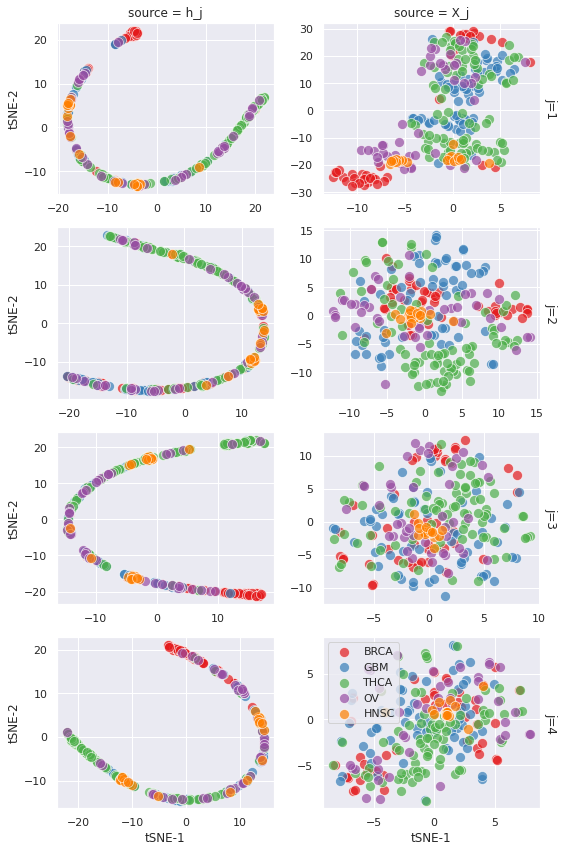

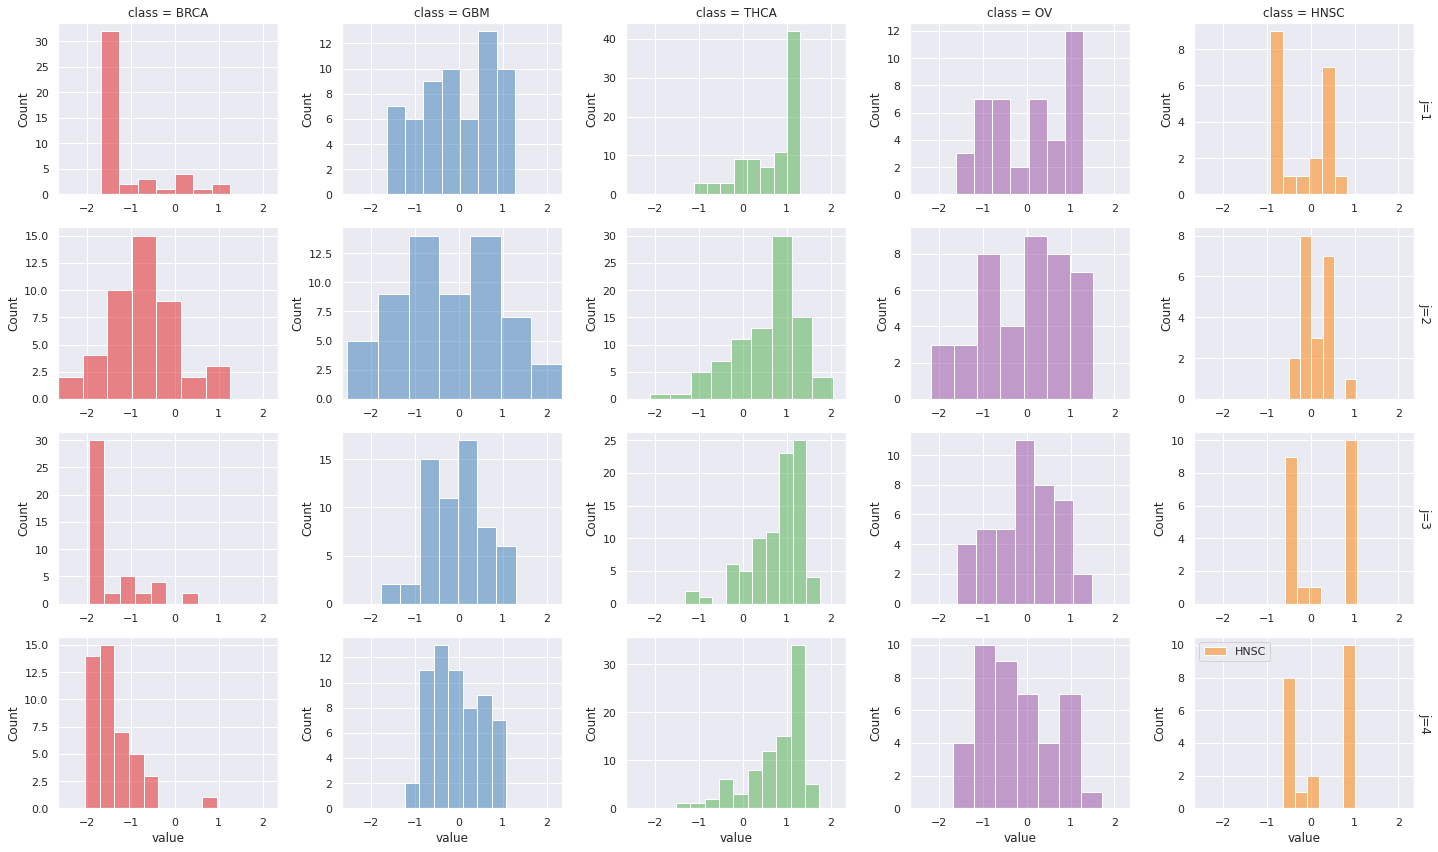

In [56]:
data = []
for j_res, j_name in zip([i for i in range(J)], [f"{j+1}" for j in range(J)]): 

    h_j = meta_results["resolution_embeddings"][j_res].cpu().numpy()
    x_j = meta_results["masked_inputs"][j_res].cpu().numpy()

    # Projection of scale embeddings, and source separated input
    for val, val_name in zip([h_j, x_j], ["h_j", "X_j"]):

        val = val.reshape((val.shape[0], -1))           # Reshape x_j to flatten channels
        val = StandardScaler().fit_transform(val)       # Scale before any transform
        
        embedding = reducer.fit_transform(val)
        for i in range(embedding.shape[0]):
            data.append([embedding[i, 0], embedding[i, 1], 
                         val_name,
                         j_name, cancer_types[lbls[i]],
                         val[i, :][0]
                        ])  

df_emb = pd.DataFrame(data, columns=[latent1, latent2, "source", "resolution", "class", "value"])
# print([_x.shape for _x in df_emb["value"]])

# Plot umap
g = sns.FacetGrid(df_emb, row="resolution", col="source", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}")
plt.legend()
plt.show()

# Plot histogram
df_hist = df_emb[df_emb["source"] == "h_j"]
g = sns.FacetGrid(df_hist, row="resolution", col="class", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.histplot, 'value', alpha=0.5);
g.set(xlim=(df_hist["value"].min(), df_hist["value"].max()))
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}")
plt.legend()
plt.show()

We find that $h_j$ benefits from the information flow through the LSTM model. Embeddings are improved by

* the additional label/task information, leading to adaptive filtering.
* the ability of the LSTM model to pass information through the recurrent cell states. E.g. Whilst the orange class was separable at $X_{j=4}$, and subsequently not - within the resolution embeddings that information has been retained for $h_{j\geq4}$. Note, this behaviour can be controlled through reducing and increasing the capacity of the hidden states.


## Plot selective resolution embeddings (paper plot)

This is the paper plot version of the above section

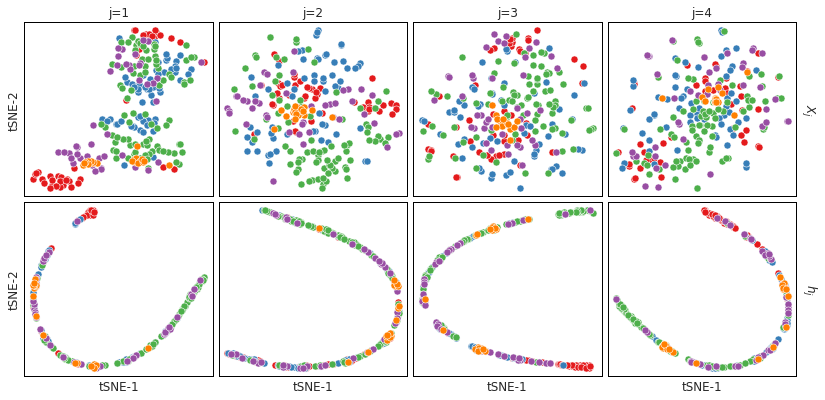

In [57]:
resolutions = [1,2,3,4]         # 1,2,3,...,J=4
sources = ["X_j", "h_j"]

df_fig2 = df_emb[df_emb["resolution"].isin([f"{i}" for i in resolutions])]
df_fig2 = df_fig2[df_fig2["source"].isin(sources)]
# df_fig2 = df_fig2[df_fig2["class"].isin([5, 6])]           # Zoom into subset of classes

g = sns.FacetGrid(df_fig2, col="resolution", row="source", hue="class", 
                  row_order=sources,
                  margin_titles=True, despine=False, height=3, aspect=1, sharex=False, sharey=False)
g.map(sns.scatterplot, f"{reduce_method}-1", f"{reduce_method}-2", alpha=1, s=50)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="j={col_name}", row_template="${row_name}$")    # {row_name}
    

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=f"{reduce_method}-1", clear_inner=True, )
g.set_ylabels(label=f"{reduce_method}-2", clear_inner=True, )

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))

# Adjust margins
# plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.gcf().set_size_inches(8, 3.5)
        
plt.savefig("resolution_embeddings.png", dpi=500, format='png', transparent=True)

## Visualisation of self-attention

We can also visualise the learnt self-attention, allowing us to see which resolutions the model thought were predictive.

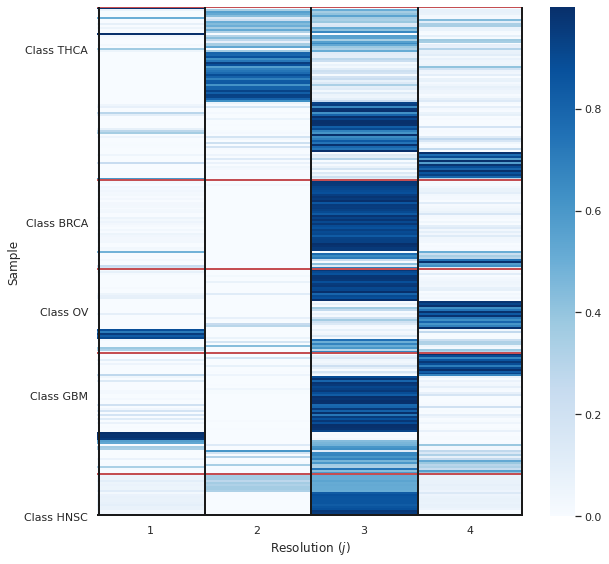

In [72]:
# Order samples by label
permute_idx = np.argsort(lbls)
ord_lbls = lbls[permute_idx]
ord_attention = A[permute_idx, :, :]

# average over attention hops:   [batch_size, num_multiscales]
ord_attention = torch.mean(ord_attention, dim=1).cpu().numpy()  

# Nested ordering (by biclustering attention)
attention_new = np.zeros_like(ord_attention)
for _lbl in np.unique(ord_lbls):
    lbl_idx = np.where(ord_lbls == _lbl)[0]
    atn_cls = ord_attention[lbl_idx, :]
    biclustering = SpectralBiclustering(n_clusters=(4, 1), method="log", random_state=0)
    biclustering.fit(atn_cls)
    atn_cls = atn_cls[np.argsort(biclustering.row_labels_)]
    attention_new[lbl_idx, :]  = atn_cls#[:, np.argsort(biclustering.column_labels_)]
attention = attention_new


# Plot
fig, ax = plt.subplots(1, 1, figsize=(9,8))
sns.heatmap(attention, ax=ax, cmap='Blues', vmin=0, yticklabels=False)   # vmax=1

# Add horizontal lines
y_tick_locations = [np.where(ord_lbls == _lbl)[0][0] for _lbl in np.unique(ord_lbls)]
for y_tick in y_tick_locations:
    ax.hlines(y=y_tick+0.1, xmin=0, xmax=20, linewidth=2, color='r')
ax.hlines(y=attention.shape[0]-0.1, xmin=0, xmax=20, linewidth=2, color='k')

# Add vertical lines
for x_tick in [i for i in range(J)]:
    ax.vlines(x=x_tick+0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')
ax.vlines(x=attention.shape[1]-0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')

    
ax.set_yticks([yi+attention.shape[0]/12 for yi in y_tick_locations])
# ax.set_yticks([], minor=True)
# ax.yaxis.grid(True, which='major', lw=1, ls='-', color='k')
ax.set_yticklabels([f"Class {cancer_types[i]}" for i in np.unique(ord_lbls)])
ax.set_xticklabels([f"{j+1}" for j in range(J)], minor=False)

ax.set_xlabel("Resolution $(j)$")
ax.set_ylabel("Sample")    # permuted

plt.tight_layout()
plt.savefig("attention.png", dpi=500, format='png', transparent=True)

## Visualisation of the multi-resolution embedding

We can visualise the embedding tensor $M$ by either flattening, or taking the average across hops. For this example $r_{\text{hops}}=1$, and so they are equivalent.

      tSNE-1     tSNE-2 source class     value
0  16.989977 -12.861783  Mflat  BRCA -3.034507
1  13.818105 -14.494665  Mflat  BRCA -2.877659
2  14.069916 -14.164604  Mflat  BRCA -2.893588
3   2.273041 -16.316605  Mflat   GBM -1.672372
4  15.961538 -13.276181  Mflat  BRCA -2.981489


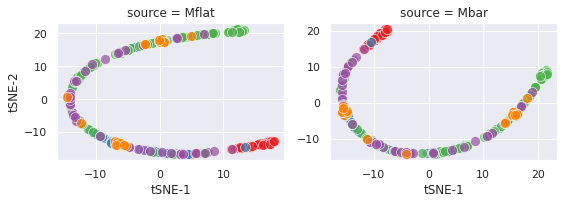

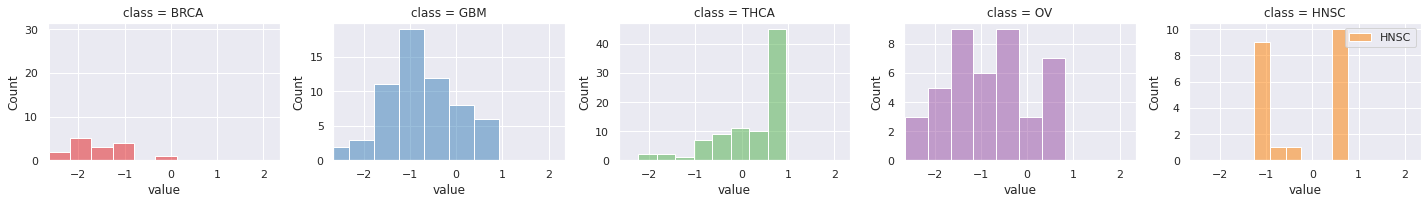

In [61]:
data = []

for Mvar, Mname in zip([Mflat, Mbar], ["Mflat", "Mbar"]):

    embedding = reducer.fit_transform(Mvar.reshape((Mvar.shape[0], -1)))

    for i in range(embedding.shape[0]):
        data.append([embedding[i, 0], embedding[i, 1], 
                     Mname,
                     cancer_types[lbls[i]],
                     Mvar[i, :][0]
                    ])  

df_mres_emb = pd.DataFrame(data, columns=[latent1, latent2, "source", "class", "value"])
print(df_mres_emb.head())

# Plot
g = sns.FacetGrid(df_mres_emb, col="source", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)


# Plot histogram
df_mres_emb = df_mres_emb[df_mres_emb["source"]=="Mflat"]
g = sns.FacetGrid(df_mres_emb, col="class", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.histplot, 'value', alpha=0.5);
g.set(xlim=(df_hist["value"].min(), df_hist["value"].max()))
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}")
plt.legend()
plt.show()